In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Deep learning
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import Embedding
from keras.layers import LSTM
import tensorflow as tf
from time import time
from keras.callbacks import TensorBoard
from keras import optimizers

import matplotlib.pyplot as plt
#from ggplot import *
%pylab inline


/Users/wz/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
# Read parkinson_data
parkinson_data = pd.read_csv("parkinsons.csv")
parkinson_data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
# Data exploration
# checking missing values
# list of feature names and disease status
print (parkinson_data.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [5]:
#Number of patients
parkinson_data.shape

(195, 24)

In [6]:
#Number of patients
n_patients = parkinson_data.shape[0]

#Number of features
n_features = parkinson_data.shape[1]-1

#With Parkinsons
n_parkinsons = parkinson_data[parkinson_data['status'] == 1].shape[0]

#Without Parkinsons
n_healthy = parkinson_data[parkinson_data['status'] == 0].shape[0]

#Result Output
print ("Total number of patients: {}".format(n_patients))
print ("Number of features: {}".format(n_features))
print ("Number of patients with Parkinsons: {}".format(n_parkinsons))
print ("Number of patients without Parkinsons: {}".format(n_healthy))

Total number of patients: 195
Number of features: 23
Number of patients with Parkinsons: 147
Number of patients without Parkinsons: 48


In [7]:
parkinson_data.groupby('status').describe()

D2                                                              \
        count      mean       std       min       25%       50%       75%   
status                                                                      
0        48.0  2.154491  0.310269  1.423287  1.974217  2.129510  2.339487   
1       147.0  2.456058  0.375742  1.765957  2.180933  2.439597  2.668479   

                    DFA              ...      spread1           spread2  \
             max  count      mean    ...          75%       max   count   
status                               ...                                  
0       2.882450   48.0  0.695716    ...    -6.350146 -5.198864    48.0   
1       3.671155  147.0  0.725408    ...    -4.664067 -2.434031   147.0   

                                                                              
            mean       std       min       25%       50%       75%       max  
status                                                                        
0       0.160292  0.062982  0.006274  0.120623  0.167356  0.193766  0.291954  
1       0.248133  0.077809  0.063412  0.199507  0.240875  0.303660  0.450493  

[2 rows x 176 columns]

In [8]:
df_a = parkinson_data.loc[parkinson_data['status'] == 0].drop('name', 1)
df_b = parkinson_data.loc[parkinson_data['status'] == 1].drop('name', 1)

In [9]:
import scipy    
_, ttest_Pvalue = scipy.stats.ttest_ind(df_a, df_b)
ttest_Pvalue

array([  3.12191940e-08,   2.02756691e-02,   4.19700418e-08,
         8.20998925e-05,   1.28225232e-06,   1.64339341e-04,
         4.25776652e-05,   1.64546645e-04,   1.26470229e-07,
         5.00074318e-07,   6.38619409e-07,   4.82357514e-07,
         1.64323777e-07,   6.39053856e-07,   7.99485052e-03,
         2.07467736e-07,   0.00000000e+00,   1.13989625e-05,
         1.11511588e-03,   7.90965087e-18,   2.39172876e-11,
         1.13592461e-06,   1.39261862e-15])

/Users/wz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  app.launch_new_instance()


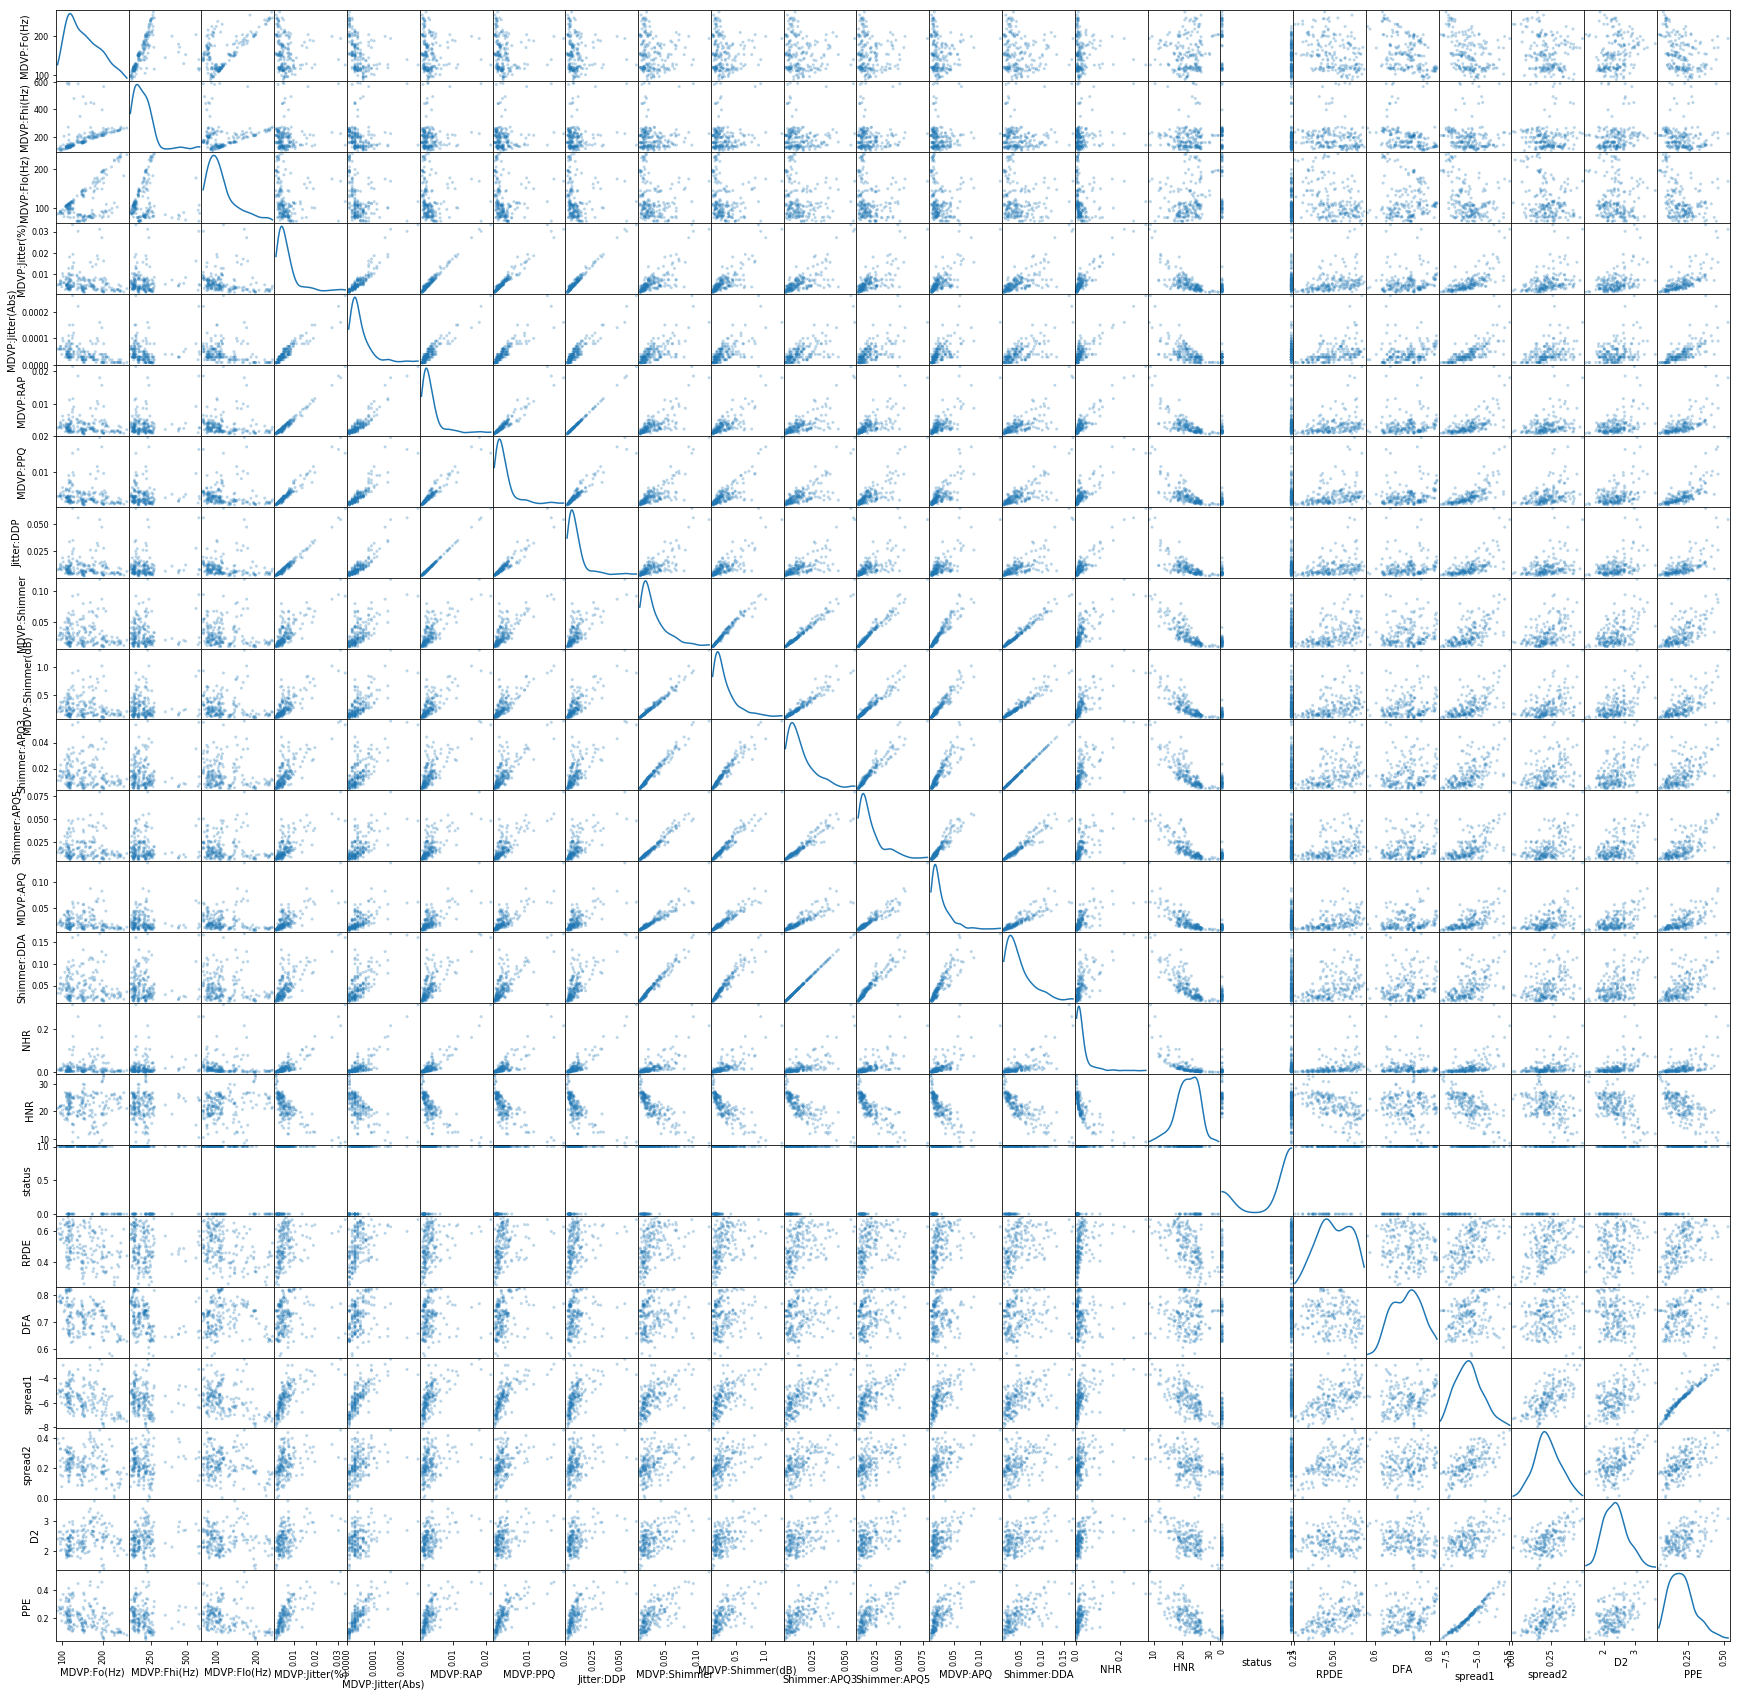

In [10]:
# Data Visualization
# sns.pairplot(parkinson_data)
pd.scatter_matrix(parkinson_data, alpha = 0.3, figsize = (30,30), diagonal = 'kde');
pylab.savefig("scatter" + ".png")

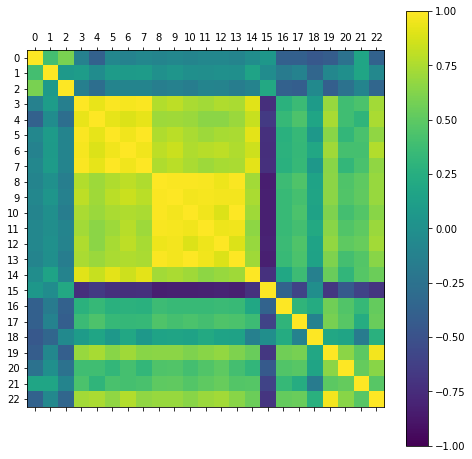

In [11]:
# correlations visuation
correlations = parkinson_data.corr()
# plot correlation matrix
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,23,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
plt.show()

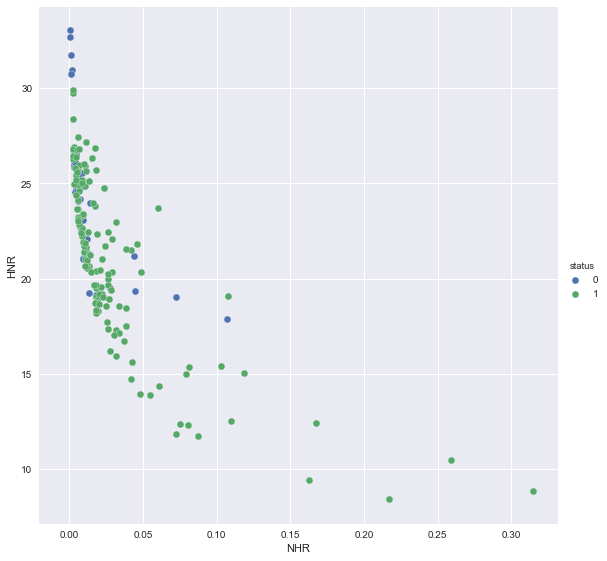

In [12]:
import seaborn as sns

sns.pairplot(x_vars=["NHR"], y_vars=["HNR"], data=parkinson_data, hue="status", size=8)

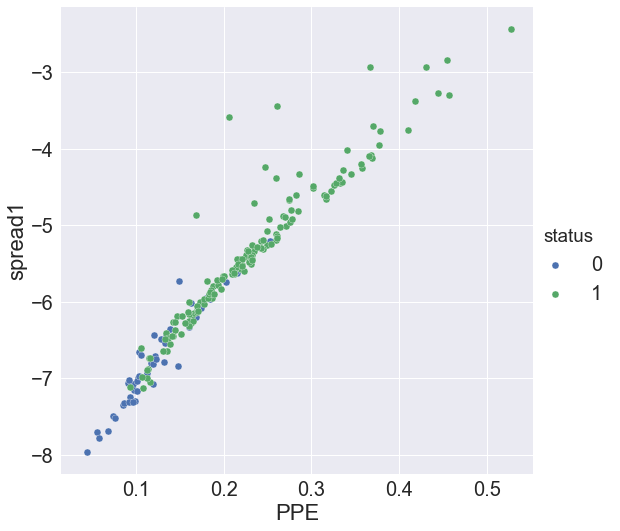

In [13]:
sns.set(font_scale=2)
sns.pairplot(x_vars=["PPE"], y_vars=["spread1"], data=parkinson_data, hue="status", size=8)

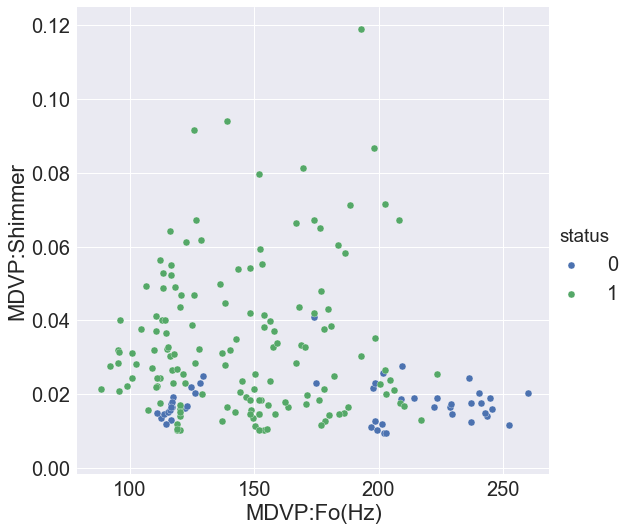

In [14]:
sns.set(font_scale=2)
sns.pairplot(x_vars=["MDVP:Fo(Hz)"], y_vars=["MDVP:Shimmer"], data=parkinson_data, hue="status", size=8)

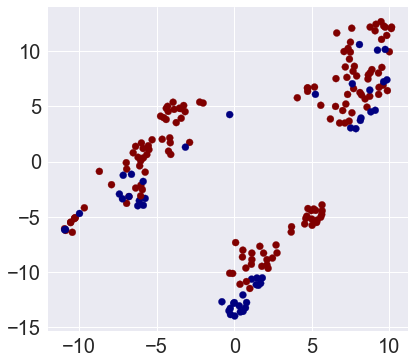

In [15]:
# TSNE dimmension reduction for visulization

from sklearn.manifold import TSNE
from matplotlib  import cm
TSNE_model = TSNE(n_components=2, random_state=0)

# Extract feature columns
feature_cols = list(parkinson_data.columns[1:16]) + list(parkinson_data.columns[18:])
target_col = parkinson_data.columns[17]

# Separate the data into feature data and target data (X_all and y_all, respectively)
X = parkinson_data[feature_cols]
Y = parkinson_data[target_col]
tsne_model = TSNE(n_components=2, random_state=0)
X_embedded = tsne_model.fit_transform(X) 

fig = figure(figsize=(5, 5))
#ax = axes(frameon=False)
#setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
scatter(X_embedded[:, 0], X_embedded[:, 1],c=Y, cmap = cm.jet)


In [16]:
# Down subample data to balance data
from sklearn.utils import resample
# Separate majority and minority classes
parkinson_data_minority = parkinson_data[parkinson_data.status==0]
parkinson_data_majority = parkinson_data[parkinson_data.status==1]

 
# Downsample majority class
parkinson_data_majority_downsampled = resample(parkinson_data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=48,     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine minority class with downsampled majority class
parkinson_downsampled = pd.concat([parkinson_data_majority_downsampled, parkinson_data_minority])
 
# Display new class counts
parkinson_downsampled.status.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

1    48
0    48
Name: status, dtype: int64

In [17]:
#Preparing the Data

# Extract feature columns
feature_cols = list(parkinson_downsampled.columns[1:16]) + list(parkinson_downsampled.columns[18:])
target_col = parkinson_downsampled.columns[17]

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = parkinson_downsampled[feature_cols]
y_all = parkinson_downsampled[target_col]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())


Feature columns:
['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

Target column: status

Feature values:
     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
7        107.332       113.840       104.315         0.00290   
24       163.656       200.841        76.779         0.00742   
27       146.845       208.701        81.737         0.00496   
144      202.544       241.350       164.168         0.00254   
179      148.143       155.982       135.041         0.00392   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
7             0.00003   0.00144   0.00182     0.00431       0.01567   
24            0.00005   0.00380   0.00390     0.01140       0.01659   
27            0.00003   0.00250   0.00275     0.00749       0.01919  

In [18]:
# Training and Testing Data Split

# Split the dataset in training (70%)  and testing (30%)
X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.3,random_state=123)
print ("Shuffling of data into test and training sets complete!")

print ("Training set: {} samples".format(X_train.shape[0]))
print ("Test set: {} samples".format(X_test.shape[0]))

Shuffling of data into test and training sets complete!
Training set: 67 samples
Test set: 29 samples


In [19]:
# Logistic regression
lg= LogisticRegression().fit(X_train, Y_train)
Y_pred_lg = lg.predict(X_test)
lg_accur = accuracy_score(Y_test, Y_pred_lg)
lg_accur

0.72413793103448276

In [111]:
# accuracy on the training data set
Y_pred_train_lg = lg.predict(X_train)
lg_train_accur = accuracy_score(Y_train, Y_pred_train_lg)
lg_train_accur

0.79104477611940294

In [20]:
# Prediction for training dataset
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred_lg))

             precision    recall  f1-score   support

          0       0.69      0.79      0.73        14
          1       0.77      0.67      0.71        15

avg / total       0.73      0.72      0.72        29



In [21]:
pd.crosstab(Y_test, Y_pred_lg, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,11,3,14
1,5,10,15
All,16,13,29


In [23]:
# Bayesian Deep learning
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import Embedding
from keras.layers import LSTM
import tensorflow as tf
from time import time
from keras.callbacks import TensorBoard

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import pymc3 as pm
import theano.tensor as tt
import theano
from scipy.stats import mode, chisquare
from sklearn.metrics import confusion_matrix, accuracy_score
import lasagne

In [25]:
x_input = X_train
test_input = X_test
y_output = pd.get_dummies(Y_train)
test_output = pd.get_dummies(Y_test)

In [26]:
ann_input = pm.floatX(preprocessing.scale(x_input))
ann_output = pm.floatX(y_output)
test_input = pm.floatX(preprocessing.scale(test_input))
test_output = pm.floatX(test_output)

In [27]:
n_hidden = 50

In [28]:
# Create shared object for future prediction
ann_input_shared = theano.shared(ann_input)

In [29]:
def make_ann(ann_input_shared, ann_output, n_hidden):
    """
    Makes a feed forward neural network with n_hidden layers for doing multi-
    class classification.
    
    Feed-forward networks are easy to define, so I have not relied on any 
    other Deep Learning frameworks to define the neural network here.
    """
    init_1 = np.random.randn(21, n_hidden)
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_out = np.random.randn(n_hidden, 2)
    
    with pm.Model() as nn_model:
        # Define weights
        weights_1 = pm.Normal('w_1', mu=0, sd=10, 
                              shape=(21, n_hidden),
                              testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=10,
                              shape=(n_hidden, n_hidden),
                              testval=init_2)
        weights_out = pm.Normal('w_out', mu=0, sd=10, 
                                shape=(n_hidden, 2),
                                testval=init_out)

        # Define activations
        acts_1 = pm.Deterministic('activations_1', 
                                  tt.tanh(tt.dot(ann_input_shared, weights_1)))
        acts_2 = pm.Deterministic('activations_2', 
                                  tt.tanh(tt.dot(acts_1, weights_2)))
        acts_out = pm.Deterministic('activations_out', 
                                    tt.nnet.softmax(tt.dot(acts_2, weights_out)))  # noqa
        
        # Define likelihood
        out = pm.Multinomial('likelihood', n=1, p=acts_out, 
                             observed=ann_output)
            
    return nn_model

In [41]:
model_1 = make_ann(ann_input_shared, ann_output, n_hidden)

/Users/wz/anaconda/lib/python3.5/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [42]:
with model_1:
    approx_1 = pm.fit(100000, 
                    callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-1)])

Average Loss = 722.09: 100%|██████████| 100000/100000 [03:05<00:00, 538.44it/s]


In [43]:
model_2 = make_ann(ann_input_shared, ann_output, n_hidden)
with model_2:
    approx_2 = pm.fit(500000, 
                    callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-1)])

/Users/wz/anaconda/lib/python3.5/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Average Loss = 404.81: 100%|██████████| 500000/500000 [16:17<00:00, 511.67it/s]


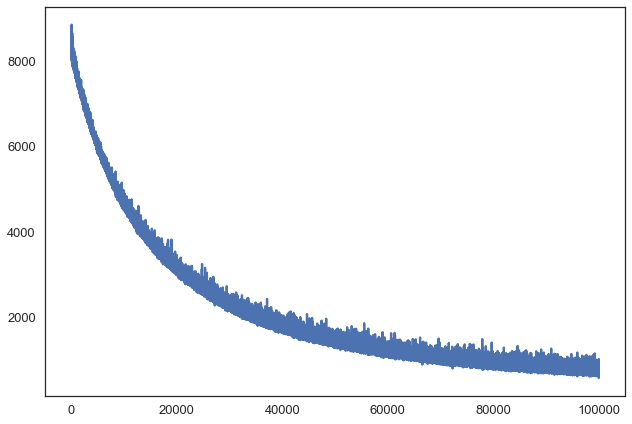

In [35]:
plt.plot(approx_1.hist)

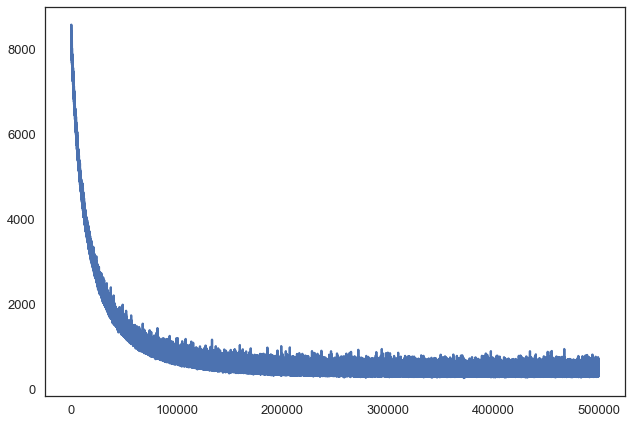

In [44]:
plt.plot(approx_2.hist)

In [36]:
with model_1:
    trace_1 = approx_1.sample(1000)

In [45]:
with model_2:
    trace_2 = approx_2.sample(1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24f62518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a250c5860>]], dtype=object)

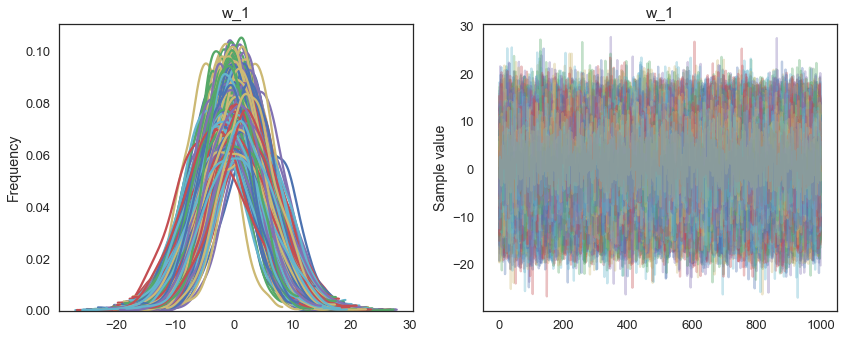

In [272]:
pm.traceplot(trace_1, figsize=(12,5), varnames=['w_1'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c49c4f208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c4943e5c0>]], dtype=object)

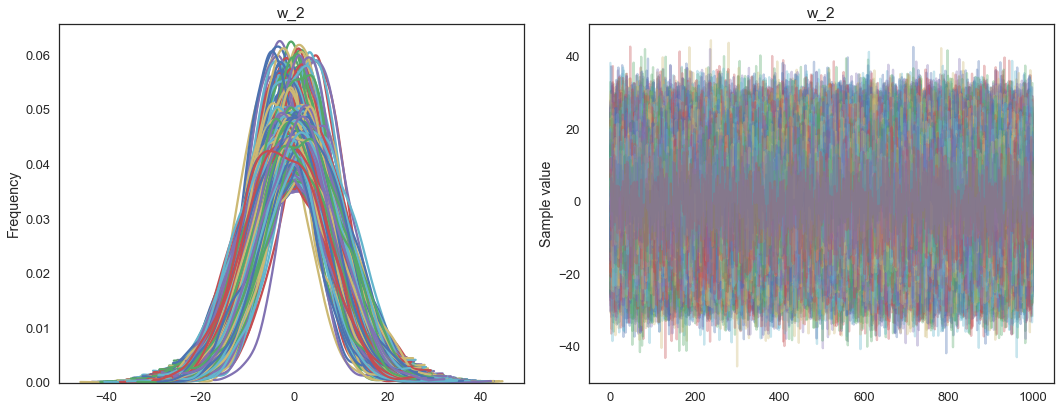

In [273]:
pm.traceplot(trace_1, figsize=(15,6), varnames=['w_2'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4f7719e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c4f74cf60>]], dtype=object)

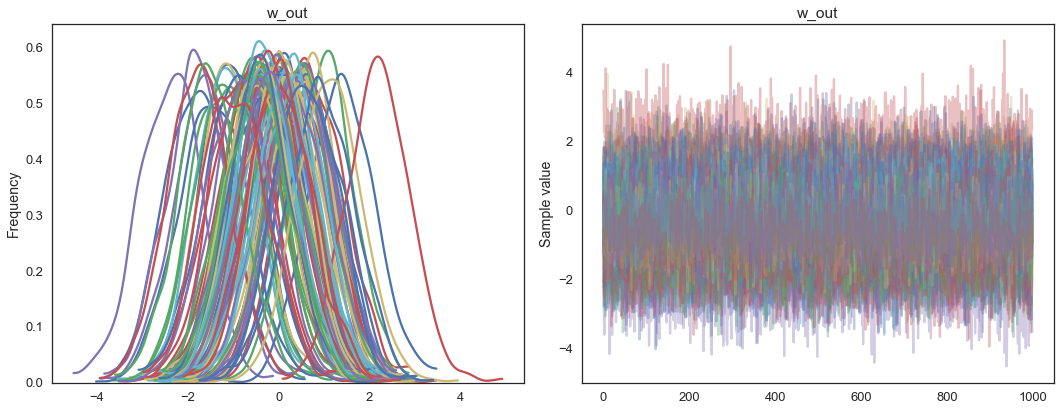

In [274]:
pm.traceplot(trace_1, figsize=(15,6), varnames=['w_out'])

In [107]:
## Extract w_out 3 coefficient traces
w_out1= trace_1['w_out'][:, 1, 0]
w_out3= trace_1['w_out'][:, 3, 0]
w_out5= trace_1['w_out'][:, 5, 0]
np.savetxt('w_out1.csv', w_out1, delimiter=',')
np.savetxt('w_out3.csv', w_out3, delimiter=',')
np.savetxt('w_out5.csv', w_out5, delimiter=',')

In [38]:
ann_input_shared.set_value(ann_input)
with model_1:
    samp_ppc_1 = pm.sample_ppc(trace_1, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1168.60it/s]


In [59]:
# ann_input_shared.set_value(ann_input)
with model_2:
    samp_ppc_2 = pm.sample_ppc(trace_2, samples=500)

100%|██████████| 500/500 [00:00<00:00, 661.67it/s]


In [39]:
preds_proba_1 = samp_ppc_1['likelihood'].mean(axis=0)
preds_1 = (preds_proba_1 == np.max(preds_proba_1, axis=1, keepdims=True)) * 1
# plt.pcolor(preds_1)
# plt.savefig('class_predictions.png', dpi=600)

In [60]:
preds_proba_2 = samp_ppc_2['likelihood'].mean(axis=0)
preds_2 = (preds_proba_2 == np.max(preds_proba_2, axis=1, keepdims=True)) * 1
# plt.pcolor(preds_1)
# plt.savefig('class_predictions.png', dpi=600)

In [108]:
# Prediction for training dataset
from sklearn.metrics import classification_report
print(classification_report(ann_output, preds_1))

             precision    recall  f1-score   support

          0       0.77      0.88      0.82        34
          1       0.86      0.73      0.79        33

avg / total       0.81      0.81      0.80        67



In [61]:
print(classification_report(ann_output, preds_2))

             precision    recall  f1-score   support

          0       0.78      0.94      0.85        34
          1       0.89      0.76      0.82        33

avg / total       0.84      0.85      0.84        67



In [109]:
pd.crosstab(Y_train, preds_2[:, 1], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,31,3,34
1,8,25,33
All,39,28,67


In [110]:
accuracy_score(Y_train, preds_2[:, 1])

0.83582089552238803

In [67]:
# Switch out the observations and use `sample_ppc` to predict
ann_input_shared.set_value(test_input)
with model_1:
    samp_ppc_test = pm.sample_ppc(trace_1, samples=500)
    
preds_proba_test = samp_ppc_test['likelihood'].mean(axis=0)
preds_test = (preds_proba_test == np.max(preds_proba_test, axis=1, keepdims=True)) * 1

100%|██████████| 500/500 [00:00<00:00, 539.30it/s]


In [69]:
# Switch out the observations and use `sample_ppc` to predict
ann_input_shared.set_value(test_input)
with model_2:
    samp_ppc_test_2 = pm.sample_ppc(trace_2, samples=500)
    
preds_proba_test_2 = samp_ppc_test_2['likelihood'].mean(axis=0)
preds_test_2 = (preds_proba_test_2 == np.max(preds_proba_test_2, axis=1, keepdims=True)) * 1

100%|██████████| 500/500 [00:00<00:00, 1259.80it/s]


In [70]:
# Prediction for testing dataset
print(classification_report(test_output, preds_test))

             precision    recall  f1-score   support

          0       0.76      0.93      0.84        14
          1       0.92      0.73      0.81        15

avg / total       0.84      0.83      0.83        29



In [71]:
# Prediction for testing dataset
print(classification_report(test_output, preds_test_2))

             precision    recall  f1-score   support

          0       0.72      0.93      0.81        14
          1       0.91      0.67      0.77        15

avg / total       0.82      0.79      0.79        29



In [72]:
pd.crosstab(Y_test, preds_test[:, 1], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,13,1,14
1,4,11,15
All,17,12,29


In [74]:
# Confusion matrix with logistic for comparison
pd.crosstab(Y_test, Y_pred_lg, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,11,3,14
1,5,10,15
All,16,13,29


In [75]:
bnn_accur = accuracy_score(Y_test, preds_test[:, 1])
bnn_accur

0.82758620689655171

In [76]:
parkinson_downsampled_sorted = parkinson_downsampled.sort_values('status')
x_all_sorted = parkinson_downsampled_sorted[feature_cols]
y_all_sorted = parkinson_downsampled_sorted[target_col]
y_all_sorted = pd.get_dummies(y_all_sorted)

In [77]:
all_input = pm.floatX(preprocessing.scale(x_all_sorted))
all_output = pm.floatX(y_all_sorted)

In [78]:
ann_input_shared.set_value(all_input)

In [79]:
# Switch out the observations and use `sample_ppc` to predict
ann_input_shared.set_value(all_input)
with model_1:
    samp_ppc_all = pm.sample_ppc(trace_1, samples=500)
    
preds_proba_all = samp_ppc_all['likelihood'].mean(axis=0)
preds_all = (preds_proba_all == np.max(preds_proba_all, axis=1, keepdims=True)) * 1

100%|██████████| 500/500 [00:01<00:00, 492.24it/s]


In [112]:
# plt.pcolor(preds_all)
# plt.savefig('class_predictions_all.png', dpi=600)

In [81]:
# Prediction for entire dataset
print(classification_report(y_all_sorted, preds_all))

             precision    recall  f1-score   support

          0       0.77      0.92      0.84        48
          1       0.90      0.73      0.80        48

avg / total       0.83      0.82      0.82        96



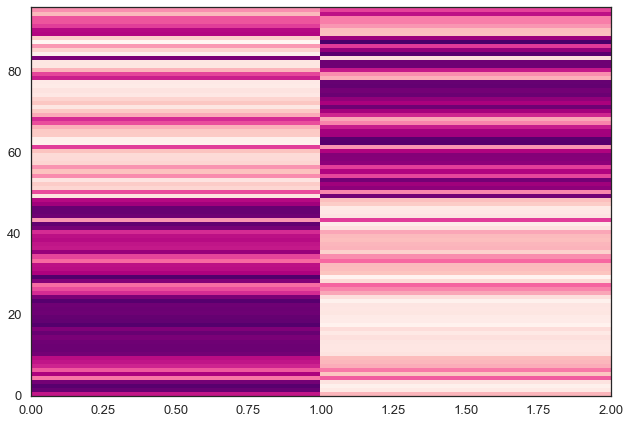

In [82]:
plt.pcolor(preds_proba_all, cmap='RdPu')
plt.savefig('class_probabilities_all.png', dpi=600)

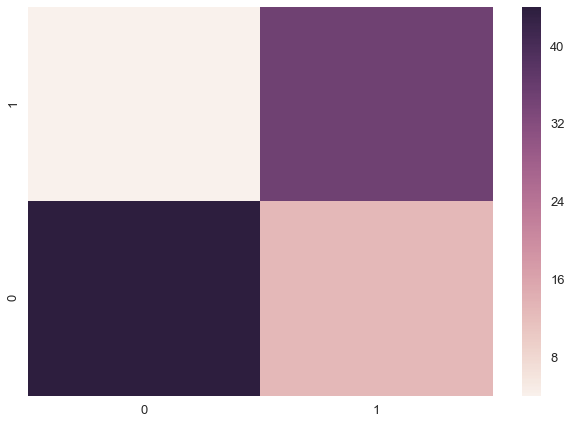

In [94]:
ax=sns.heatmap(confusion_matrix(preds_all[:, 1], parkinson_downsampled_sorted[target_col]))
ax.invert_yaxis()

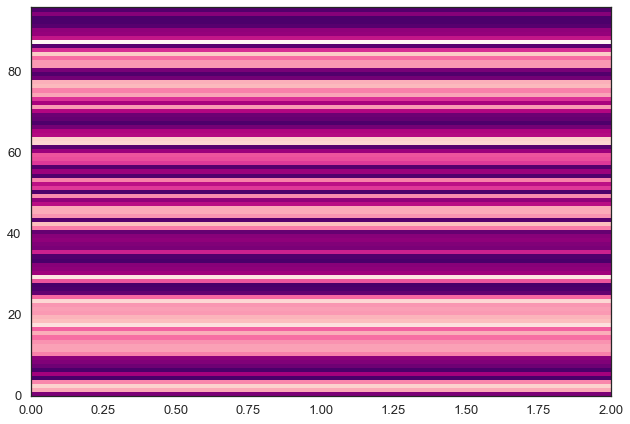

In [105]:
plt.pcolor(samp_ppc_all['likelihood'].std(axis=0), cmap='RdPu')
plt.savefig('class_uncertainties.png', dpi=600)

In [ ]:
# Metro Hasting algorithms
def make_ann_mh(ann_input_shared, ann_output, n_hidden):
    """
    Makes a feed forward neural network with n_hidden layers for doing multi-
    class classification.
    
    Feed-forward networks are easy to define, so I have not relied on any 
    other Deep Learning frameworks to define the neural network here.
    """
    init_1 = np.random.randn(21, n_hidden)
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_out = np.random.randn(n_hidden, 2)
    
    with pm.Model() as nn_model:
        # Define weights
        weights_1 = pm.Normal('w_1', mu=0, sd=10, 
                              shape=(21, n_hidden),
                              testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=10,
                              shape=(n_hidden, n_hidden),
                              testval=init_2)
        weights_out = pm.Normal('w_out', mu=0, sd=10, 
                                shape=(n_hidden, 2),
                                testval=init_out)

        # Define activations
        acts_1 = pm.Deterministic('activations_1', 
                                  tt.tanh(tt.dot(ann_input_shared, weights_1)))
        acts_2 = pm.Deterministic('activations_2', 
                                  tt.tanh(tt.dot(acts_1, weights_2)))
        acts_out = pm.Deterministic('activations_out', 
                                    tt.nnet.softmax(tt.dot(acts_2, weights_out)))  # noqa
        
        # Define likelihood
        out = pm.Multinomial('likelihood', n=1, p=acts_out, 
                             observed=ann_output)
            
    return nn_model

In [140]:
model_2 = make_ann_mh(ann_input_shared, ann_output, n_hidden)

/Users/wz/anaconda/lib/python3.5/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [113]:
# Failed to run ()
# with model_2:
#    step = pm.Metropolis()
#    trace_s = pm.sample(50000, step)

In [ ]:
pm.traceplot(trace_s, figsize=(15,6), varnames=['w_out'])

In [106]:
# Creat tensor graph
# Due to lack of the computation support for pymc3,
# tensor graph was made with tensorflow with the same neural network archieture
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import Embedding
from keras.layers import LSTM
import tensorflow as tf
from time import time
from keras.callbacks import TensorBoard

model = Sequential()
model.add(Dense(50, input_dim=21, kernel_initializer='normal'))
model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(50, kernel_initializer='normal'))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=['accuracy'])

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Fit the model
#model.fit(X_train.values, Y_train.values, epochs = 100)
model.fit(X_train.values, Y_train.values, epochs = 1000, verbose=0, callbacks=[tbCallBack])

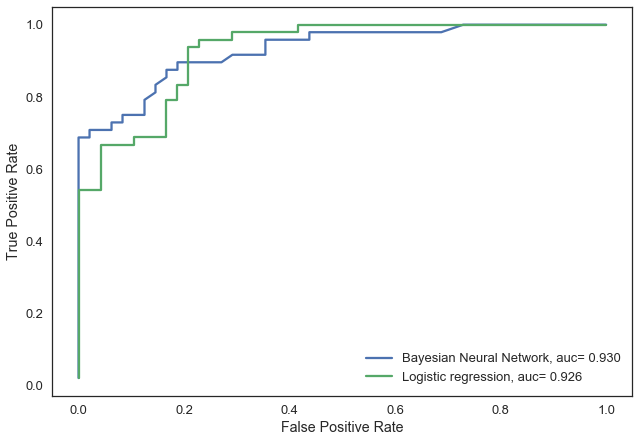

In [365]:
plt.figure(0).clf()

preds = preds_proba_all[:, 1]
fpr, tpr, _ = metrics.roc_curve(parkinson_downsampled_sorted[target_col], preds)
auc = metrics.roc_auc_score(parkinson_downsampled_sorted[target_col], preds)
df_lr = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr,label="Bayesian Neural Network, auc= %0.3f" %(auc))

# preds = random_forest.predict_proba(x_all_sorted)[:,1]
# fpr, tpr, _ = metrics.roc_curve(parkinson_downsampled_sorted[target_col], preds)
# auc = metrics.roc_auc_score(parkinson_downsampled_sorted[target_col], preds)
# df_lr = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
# plt.plot(fpr,tpr,label="Random Forest, auc= %0.3f" %(auc))

preds = lg.predict_proba(x_all_sorted)[:,1]
fpr, tpr, _ = metrics.roc_curve(parkinson_downsampled_sorted[target_col], preds)
auc = metrics.roc_auc_score(parkinson_downsampled_sorted[target_col], preds)
df_lr = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr,label="Logistic regression, auc= %0.3f" %(auc))


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)

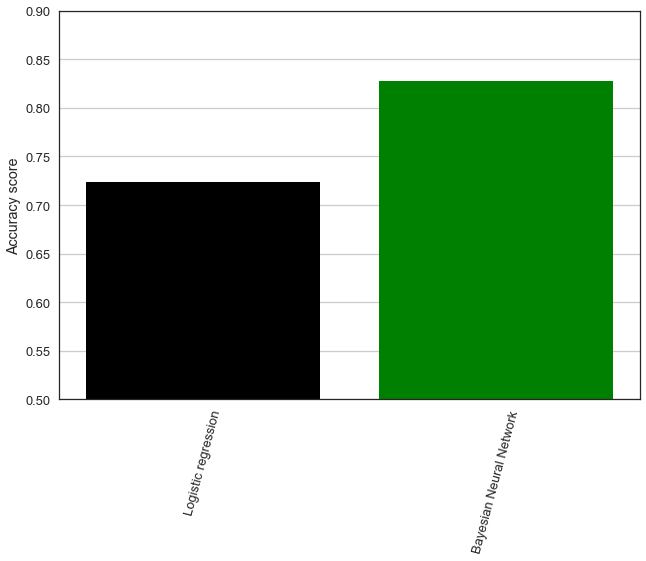

In [357]:
accuracy =  [lg_accur, bnn_accur]
objects = ('Logistic regression', "Bayesian Neural Network" )
y_pos = np.arange(len(objects))
bar_width = 0.05
plt.ylim(0.5, 0.9)
plt.bar(y_pos, accuracy, align='center', color=['black', 'g'] )
plt.gca().yaxis.grid(True)
plt.xticks(y_pos, objects)
plt.xticks(rotation=75)
plt.ylabel('Accuracy score') 
plt.show()